## ASSIGNMENT - LAB07

## NIKHITHA ELEZEBETH BABY - 21BDA14

## QUESTION - 3

## CLASSIFICATION USING CNN MODEL

In [9]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [10]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt  
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img

## Preparing Dataset

In [11]:
PATH='C:/Users/HP/Downloads/test'

In [12]:
print(os.listdir('C:/Users/HP/Downloads/test'))

['baseball', 'basketball', 'beachballs', 'billiard ball', 'bowling ball', 'brass', 'buckeyballs', 'cannon ball', 'cricket ball', 'eyeballs', 'football', 'golf ball', 'marble', 'meat ball', 'medicine ball', 'paint balls', 'pokeman balls', 'puffballs', 'screwballs', 'soccer ball', 'tennis ball', 'tether ball', 'volley ball', 'water polo ball', 'wiffle ball', 'wrecking ball']


In [13]:
label_code = {'buckeyballs':0, 'brass':1, 'screwballs':2, 'medicine ball':3, 'puffballs':4, 'bowling ball':5, 'beachballs':6, 'volley ball':7, 'football':8, 'meat ball':9, 'tennis ball':10, 'pokeman balls':11, 'baseball':12, 'water polo ball':13, 'tether ball':14, 'billiard ball':15, 'golf ball':16, 'marble':17, 'cannon ball':18, 'soccer ball':19, 'basketball':20, 'wiffle ball':21, 'eyeballs':22, 'wrecking ball':23, 'paint balls':24, 'cricket ball':25}
label_decode = ['buckeyballs', 'brass', 'screwballs', 'medicine ball', 'puffballs', 'bowling ball', 'beachballs', 'volley ball', 'football', 'meat ball', 'tennis ball', 'pokeman balls', 'baseball', 'water polo ball', 'tether ball', 'billiard ball', 'golf ball', 'marble', 'cannon ball', 'soccer ball', 'basketball', 'wiffle ball', 'eyeballs', 'wrecking ball', 'paint balls', 'cricket ball']

In [14]:
i = 0
for dirname, _, filenames in os.walk('C:/Users/HP/Downloads/train'):
    for filename in filenames:
        i += 1
print(i)

3051


In [15]:
i = 0
for dirname, _, filenames in os.walk('C:/Users/HP/Downloads/valid'):
    for filename in filenames:
        i += 1
print(i)

130


In [22]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    PATH,
    validation_split=VALID_SPLIT,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

# Get validation image with generator
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    PATH,
    validation_split=VALID_SPLIT,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

Found 130 files belonging to 26 classes.
Using 91 files for training.
Found 130 files belonging to 26 classes.
Using 39 files for validation.



load data in array

In [23]:
from tensorflow.keras.applications.xception import preprocess_input

In [24]:
IMG_SIZE = (256, 256)
VALID_SPLIT = 0.3
BATCH_SIZE = 32
SEED = 42

In [25]:
classes = train_ds.class_names

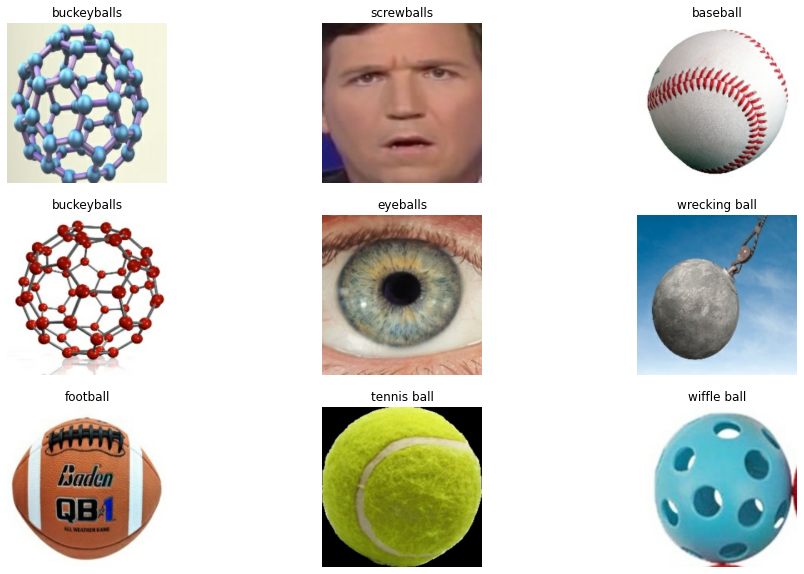

In [26]:
plt.figure(figsize=(16, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[np.argmax(labels[i])])
        plt.axis("off")

## Model Setup

In [27]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
])

# Apply transformation to train data
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
augmented_train_ds = augmented_train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [28]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 512]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    return keras.Model(inputs, outputs)

print(IMG_SIZE + (3,))
model = make_model(input_shape=IMG_SIZE + (3,), num_classes=len(classes))

(256, 256, 3)


In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_1 (Sequential)      (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['sequential_1[0][0]']           
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['rescaling[0][0]']          

                                                                                                  
 activation_7 (Activation)      (None, 32, 32, 512)  0           ['batch_normalization_6[0][0]']  
                                                                                                  
 separable_conv2d_5 (SeparableC  (None, 32, 32, 512)  267264     ['activation_7[0][0]']           
 onv2D)                                                                                           
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 32, 32, 512)  2048       ['separable_conv2d_5[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 16, 16, 512)  0          ['batch_normalization_7[0][0]']  
          

In [35]:
ok = True

if ok:
    # Parameters
    EPOCHS = 10
    CALLBACK = [
        keras.callbacks.ModelCheckpoint(filepath='./model.{epoch:02d}-{val_loss:.2f}.h5'),
        keras.callbacks.EarlyStopping(patience=15)
    ]
    
    model.compile(
        optimizer='adam',
        loss="categorical_crossentropy",
        metrics=["categorical_accuracy"],
    )
    
    history = model.fit(
        augmented_train_ds,
        epochs=EPOCHS,
        callbacks=CALLBACK,
        validation_data=val_ds,
    )
    
else:
    model = keras.models.load_model('./balls-classification-keras-cnn/save_at_')

Epoch 1/10


KeyboardInterrupt: 

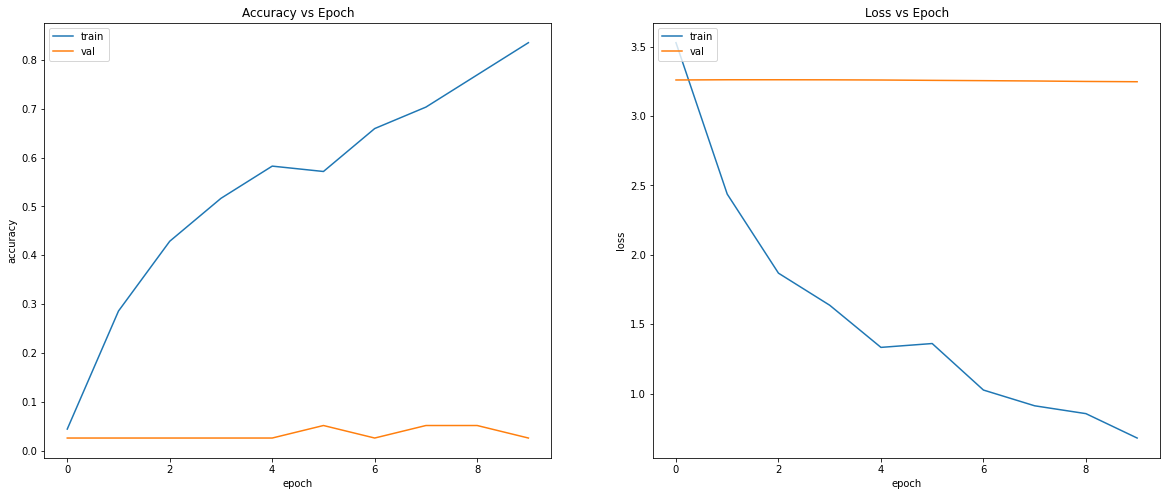

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Summarize history for accuracy
ax[0].plot(history.history['categorical_accuracy'])
ax[0].plot(history.history['val_categorical_accuracy'])
ax[0].set_title('Accuracy vs Epoch')
ax[0].set(xlabel='epoch', ylabel='accuracy')
ax[0].legend(['train', 'val'], loc='upper left')

# Summarize history for loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Loss vs Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
ax[1].legend(['train', 'val'], loc='upper left')

# Display plots
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


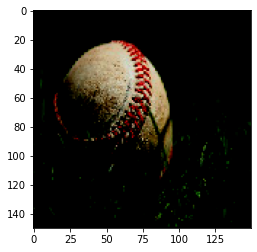

In [34]:
path2 = 'C:/Users/HP/Downloads/test/baseball/3.jpg'
img = load_img(path2, color_mode = "rgb", target_size=(150, 150))  #h, w
img = np.array(img, dtype = 'float32')
img = preprocess_input(img)
plt.imshow(img)
img = img.reshape(1,150,150,3)